In [254]:
#Для производственного использования я бы сделал пакет, который включал в себя
#data_prepare.py - модуль, в котором все классы/функции, которые используются для подготовки данных
#analytics.py - модуль, в котором находятся функции, используя которые можно выводить разнообразные графики
# для анализа данных 
#solver.py - модуль, в котором находятся классы, 
# в которых используются/реализованы модели(Holt Winters, Linear Regression и другие)
#main.py - точка входа, использует модули(data_prepare.py, analytics.py, solver.py)

In [192]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from math import sqrt
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, BayesianRidge

In [193]:
%config InlineBackend.figure_format = 'svg'

In [194]:
init_notebook_mode(connected=True)

In [195]:
def read_from_csv(filename):
    df = pd.read_csv(filename, names=['time', 'value'], index_col=['time'], parse_dates=['time'], infer_datetime_format=True)
    df.drop(df[df.value == np.inf].index, inplace=True)
    df.index = df.index.astype(str).str[:-6]
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    df.sort_index(inplace=True)
    df = df.resample('D').mean()
    return df
df = read_from_csv('test.csv')
df = df.interpolate(method='time')

In [20]:
df.head()

,value
time,
1990-01-02,2.817076
1990-01-03,2.870715
1990-01-04,2.949055
1990-01-05,3.018716
1990-01-06,3.005308


In [21]:
df.tail()

,value
time,
2020-04-18,3.689403
2020-04-19,3.719783
2020-04-20,3.750162
2020-04-21,3.785576
2020-04-22,3.707037


In [22]:
df['year'] = df.index.year
train = df.where(df.year <= 2010).dropna().drop(columns='year')
test = df.where(df.year > 2010).dropna().drop(columns='year')

In [28]:
def plot_two_figures(df_train, df_test, title):
    plt.figure(figsize=(12,5))
    plt.title(title)
    ax1 = df_train.value.plot(color='blue', grid=True, label='Train')
    ax2 = df_test.value.plot(color='red', grid=True, label='Test')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2, loc=2)
    plt.show()
def plot_three_figures(df_train, df_test, df_predict, title):
    plt.figure(figsize=(12,5))
    plt.title(title)
    ax1 = df_train.value.plot(color='blue', grid=True, label='Train')
    ax2 = df_test.value.plot(color='red', grid=True, label='Test')
    ax3 = df_predict.value.plot(color='green', grid=True, label='Predict')
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    h3, l3 = ax3.get_legend_handles_labels()
    plt.legend(h1+h2+h3, l1+l2+l3, loc=3)
    plt.show()
def plot_figure(df, title, color='blue'):
    plt.figure(figsize=(12,5))
    plt.title(title)
    ax1 = df.value.plot(color=color, grid=True, label='Value')
    h1, l1 = ax1.get_legend_handles_labels()
    plt.legend(h1, l1, loc=1)
    plt.show()
    
def calculate_rmse(df_test, df_predict):
    rms = sqrt(mean_squared_error(df_test.value, df_predict.value))
    return rms

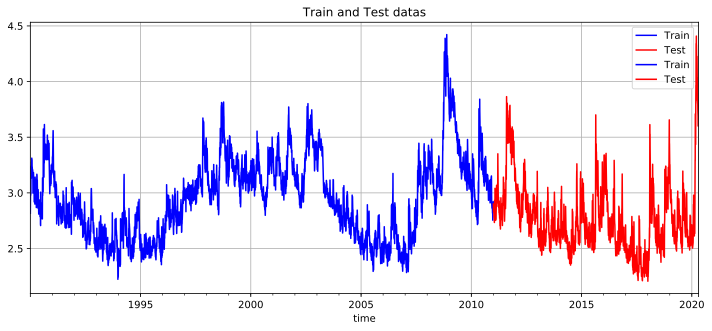

In [27]:
plot_two_figures(train, test, 'Train and Test datas')

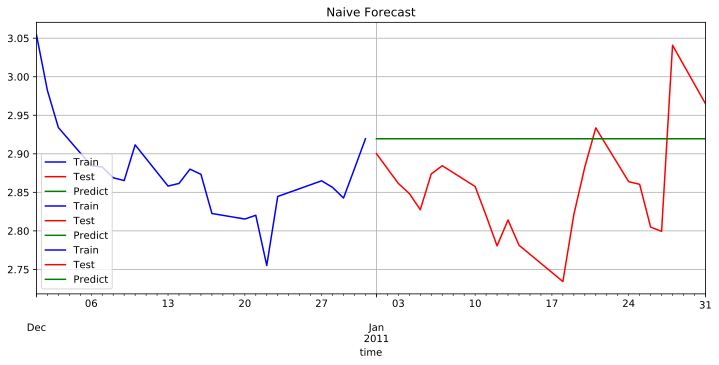

In [227]:
df_naive_forecast = test.copy()
df_naive_forecast['value'] = train.value[len(train) - 1]
plot_three_figures(train[-31:], test[:31], df_naive_forecast[:31], 'Naive Forecast')

In [244]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_naive_forecast[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:7], df_naive_forecast[:7]))

RMSE(15 days) = 0.0866131795010786
RMSE(7 days) = 0.05612715913701631


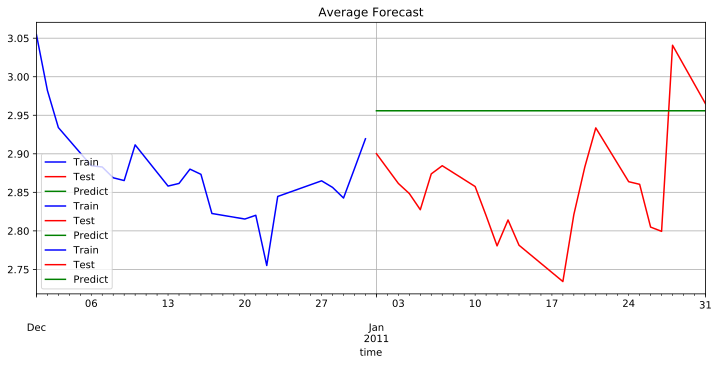

In [226]:
df_avg_forecast = test.copy()
df_avg_forecast['value'] = train.value.mean()
plot_three_figures(train[-31:], test[:31], df_avg_forecast[:31], 'Average Forecast')

In [245]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_avg_forecast[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:7], df_avg_forecast[:7]))

RMSE(15 days) = 0.11999619690698085
RMSE(7 days) = 0.09058747015553842


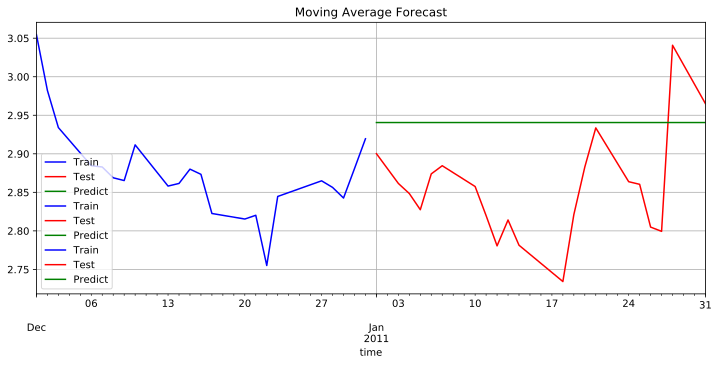

In [225]:
df_moving_avg_forecast = test.copy()
df_moving_avg_forecast['value'] = train.value.rolling(60).mean().iloc[-1]
plot_three_figures(train[-31:], test[:31], df_moving_avg_forecast[:31], 'Moving Average Forecast')

In [246]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_moving_avg_forecast[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:7], df_moving_avg_forecast[:7]))

RMSE(15 days) = 0.10574863460063237
RMSE(7 days) = 0.07591147248264919


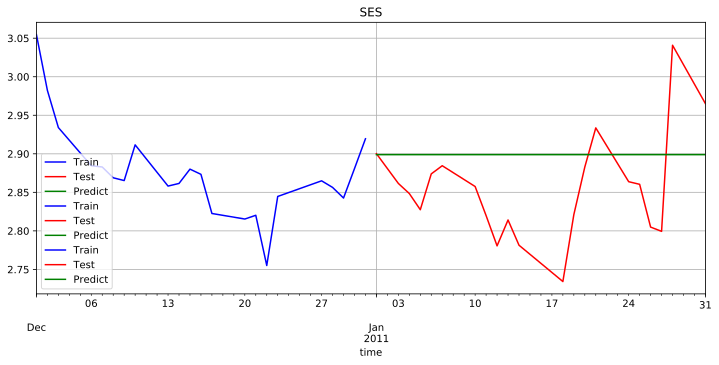

In [232]:
df_ses_forecast = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['value'])).fit(smoothing_level=0.6,optimized=False)
df_ses_forecast['value'] = fit2.forecast(len(df_ses_forecast['value']))
plot_three_figures(train[-31:], test[:31], df_ses_forecast[:31], 'SES')

In [247]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_ses_forecast[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:15], df_ses_forecast[:15]))

RMSE(15 days) = 0.06904866502989918
RMSE(7 days) = 0.06904866502989918


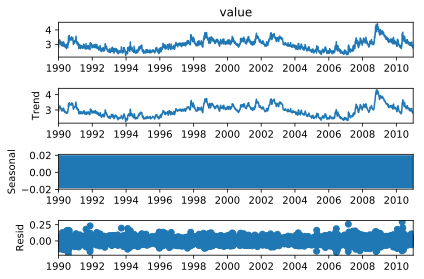

In [18]:
sm.tsa.seasonal_decompose(train.value).plot()
result = sm.tsa.stattools.adfuller(train.value)
plt.show()

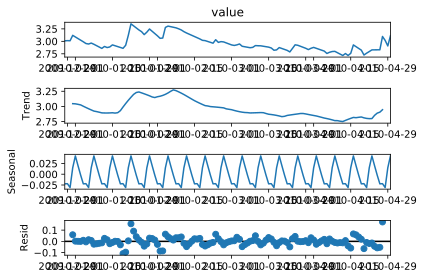

In [29]:
sm.tsa.seasonal_decompose(train.value[365 * 20:365 * 20 + 124]).plot()
result = sm.tsa.stattools.adfuller(train.value[365 * 20:365 * 20 + 124])
plt.show()

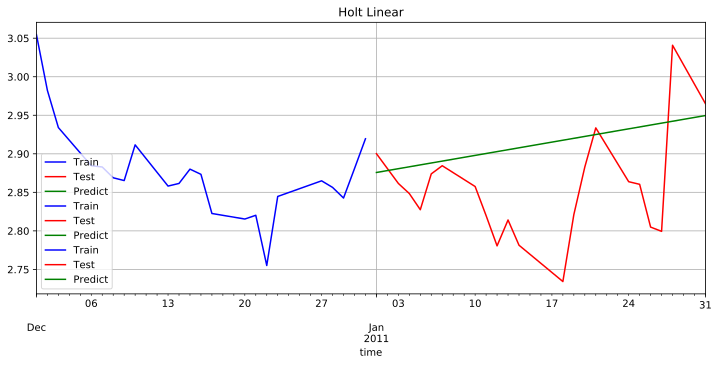

In [223]:
df_holt_linear = test.copy()
fit3 = Holt(np.asarray(train['value'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
df_holt_linear['value'] = fit3.forecast(len(test))
plot_three_figures(train[-31:], test[:31], df_holt_linear[:31], 'Holt Linear')

In [248]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_holt_linear[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:7], df_holt_linear[:7]))

RMSE(15 days) = 0.07028327130396354
RMSE(7 days) = 0.028774217359139518


/home/cat/test/test-env/lib/python3.5/site-packages/statsmodels-0.11.1-py3.5-linux-x86_64.egg/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



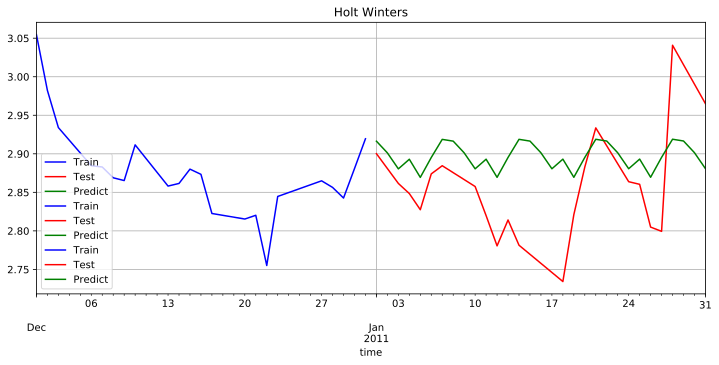

In [222]:
df_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['value']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
df_hat_avg['value'] = fit1.forecast(len(test))
plot_three_figures(train[-31:], test[:31], df_hat_avg[:31], 'Holt Winters')

In [249]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_hat_avg[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:7], df_hat_avg[:7]))

RMSE(15 days) = 0.0683655023835803
RMSE(7 days) = 0.03022735542657668


In [238]:
df_arima = test.copy ()
fit1 = sm.tsa.statespace.SARIMAX(train.value, order = (2, 1, 4), season_order = (0,1,1,7)).fit()
df_arima.value = fit1.predict(start='2011-01-01', end='2020-12-31',dynamic = True)


/home/cat/test/test-env/lib/python3.5/site-packages/statsmodels-0.11.1-py3.5-linux-x86_64.egg/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



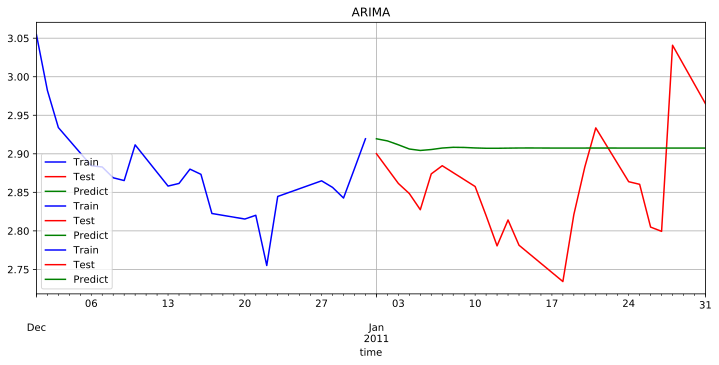

In [239]:
plot_three_figures(train[-31:], test[:31], df_arima[:31], 'ARIMA')

In [250]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_arima[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:7], df_arima[:7]))

RMSE(15 days) = 0.07642010480994958
RMSE(7 days) = 0.04622612551377899


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb967fd8780>]],
      dtype=object)

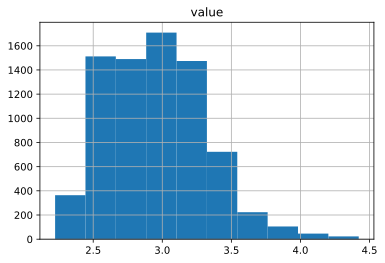

In [31]:
train.hist()

In [33]:
train['time'] = pd.to_datetime(train.index)
train['time'] = train['time'].map(dt.datetime.toordinal)
test['time'] = pd.to_datetime(test.index)
test['time'] = test['time'].map(dt.datetime.toordinal)
X_train = train.time.values
y_train = train.value.values
X_test = test.time.values
y_test = test.value.values

In [196]:
def prepare_data(y_train, window, num_samples):
    
    X_mat = []
    y_mat = []
    
    for i in range(num_samples):
        X_mat.append(y_train[i: i + window])
        y_mat.append(y_train[i + window: i + window + 1])
    
    X_mat = np.vstack(X_mat)
    y_mat = np.concatenate(y_mat)
    
    assert X_mat.shape == (num_samples, window)
    assert len(y_mat) == num_samples
    
    return X_mat, y_mat

def create_regressor_using_X(X_mat, y_mat, regressor_func=LinearRegression):
    
    regressor = regressor_func(fit_intercept=False)
    regressor = regressor.fit(X_mat, y_mat)
    
    return regressor

def prediction_using_regressor(regressor, window, start_sample, num_pred_samples):
    
    y_pred = start_sample.copy()
    
    for _ in range(num_pred_samples):
        pred_buf = regressor.predict([y_pred[-1 * window:]])
        y_pred = np.append(y_pred, pred_buf)
        
    return y_pred

In [219]:
window = 70
X_mat, y_mat = prepare_data(y_train, window, len(y_train) - window)
regressor = create_regressor_using_X(X_mat, y_mat)
y_pred = prediction_using_regressor(regressor, window, y_train[-1 * window:], len(X_test))[window:]

df_lin_reg_predict = pd.DataFrame({'time': X_test.flatten(), 'value': y_pred.flatten()})
df_lin_reg_predict.time = df_lin_reg_predict.time.apply(lambda d: dt.datetime.fromordinal(int(d)).strftime('%Y-%m-%d'))
df_lin_reg_predict.index = pd.to_datetime(df_lin_reg_predict.time, format='%Y-%m-%d %H:%M:%S')

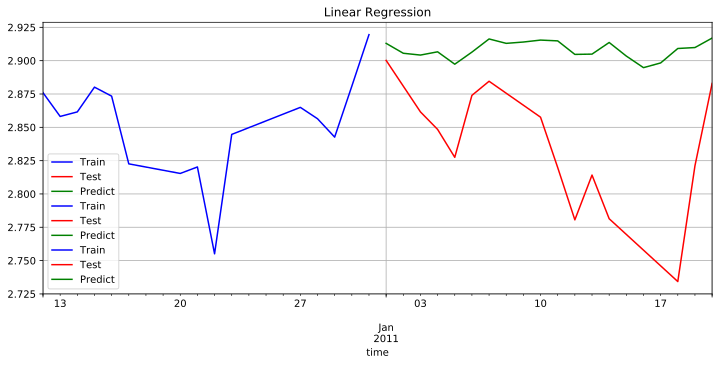

In [243]:
plot_three_figures(train[-20:], test[:20], df_lin_reg_predict[:20], 'Linear Regression')

In [252]:
print("RMSE(15 days) =", calculate_rmse(test[:15], df_lin_reg_predict[:15]))
print("RMSE(7 days) =", calculate_rmse(test[:7], df_lin_reg_predict[:7]))

RMSE(15 days) = 0.07659226209116819
RMSE(7 days) = 0.04296531085632569


In [253]:
#Получены наилучшие результаты используя метод Holt Winters,
#по результатам предикшена можно наблюдать схожую сезонность с тестовыми данными на 7 дней вперед
#RMSE(7 days) = 0.03022735542657668

#Используя метод Holt Linear
#RMSE(7 days) = 0.028774217359139518
#метод дал меньшую погрешность на 7 дней вперед, но сезонность наблюдать мы не можем
#использовать данный метод для прогноза не возможно

#Используя метод Holt Winters, можно наблюдать сезонность на 7 дней вперед